# Análise de Sobrevivência

Baseado e adaptado no código de survival analysis da IBM.

## Tópicos:

Serão abordados os seguintes aspectos, sequencialmente:

1. Como foi aplicado a análise de sobrêvivencia.
2. Preparar a curva de sobrevida de Kaplan-Meier para vários subgrupos.

__Notas de Instalação:__
Será utilizada a seguinte biblioteca: [lifelines](https://lifelines.readthedocs.io/en/latest/). Na qual pode ser instalada pelo seguinte comando:

```conda install -c conda-forge lifelines```

ou

```pip install lifelines```

In [21]:
# Instalando as bibliotecas para realizar a análise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
import warnings
from colorsetup import colors, palette
sns.set_palette(palette)

---

# Seção 1: Importação dos dados a serem analisados

Os dados importados a seguir foram obtidos a partir de vários testes de carga de curto período que tinham como objetivo derrubar uma aplicação de cadastro.

In [22]:
df = pd.read_csv('LoadTest.csv', sep=";")
df

,time,initial_users,max_users,avg_reponse_time,max_reponse_time,dead
0,115,820,958,1910,20246,1
1,114,650,941,1567,17098,1
2,79,7,459,148,700,0
3,180,7,480,159,710,0
4,46,0,300,96,651,0
...,...,...,...,...,...,...
495,166,820,958,1910,20246,1
496,126,8,700,310,1346,0
497,30,0,988,2005,21546,1
498,158,20,500,170,1300,0


Temos então, variáveis que indicam os picos de cada teste, a variável  `dead` (indica se a aplicação sobreiveu ou não ao teste de carga), e  `time` (duração em segundos de cada teste).

In [10]:
df = df.reset_index()  # make sure indexes pair with number of rows
df

,index,time,initial_users,max_users,avg_reponse_time,max_reponse_time,dead
0,0,115,820,958,1910,20246,1
1,1,114,650,941,1567,17098,1
2,2,79,7,459,148,700,0
3,3,180,7,480,159,710,0
4,4,46,0,300,96,651,0
...,...,...,...,...,...,...,...
495,495,166,820,958,1910,20246,1
496,496,126,8,700,310,1346,0
497,497,30,0,988,2005,21546,1
498,498,158,20,500,170,1300,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   time              500 non-null    int64
 1   initial_users     500 non-null    int64
 2   max_users         500 non-null    int64
 3   avg_reponse_time  500 non-null    int64
 4   max_reponse_time  500 non-null    int64
 5   dead              500 non-null    int64
dtypes: int64(6)
memory usage: 23.6 KB


<AxesSubplot:xlabel='dead', ylabel='time'>

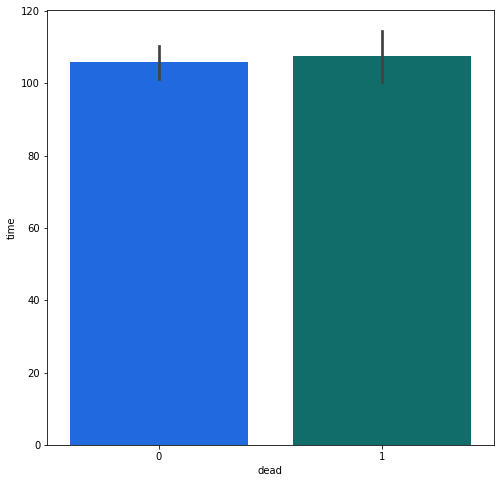

In [25]:
plt.figure(figsize=(8,8))
sns.barplot(data=df, x='dead', y='time')

É possível observar que os testes em que aplicação não sobreviveu possuem um tempo um pouco maior, isto ocorre por que em teste de cargas mais longos, abre um período de tempo maior em que aplicação deve resistir, logo a probabilidade do sistema falhar aumenta. Contudo, isto depende também da carga aplicada no teste.

# Seção 2: Usando a curva de sobrevida de Kaplan-Meier

A Curva de Kaplan-Meier representa uma visualização não paramétrica simples da função de probabilidade de sobrevivência dos nossos dados. Contudo, esta curva é inicialmente o suficiente para ter uma visualização básica da análise de sobrevivência do nosso sistema. O código abaixo demonstra a aplicação da curva de Kaplan-Meier simples.

Text(0, 0.5, 'Survival probability')

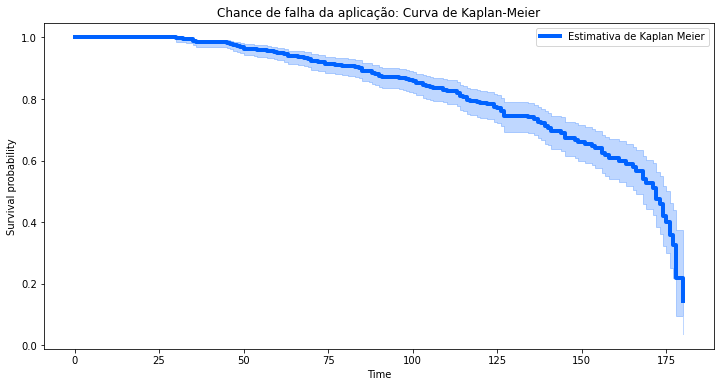

In [26]:
from lifelines.utils import datetimes_to_durations

kmf = KaplanMeierFitter()

kmf.fit(df.time, df.dead, label = 'Estimativa de Kaplan Meier')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Chance de falha da aplicação: Curva de Kaplan-Meier')
plt.xlabel('Time')
plt.ylabel('Survival probability')

# Seção 3: Examinando as outras variáveis

Ainda explorando alguns aspectos da função de sobrevivência, também podemos analisar a taxa de sobrevivência de acordo com outras variáveis. Em sequência, veremos as diferenças no risco de sobrevivência para diferentes picos de usuários. Primeiramente traçando um histograma simples para cada categoria, observando as diferenças entre subamostras e verificando se aplicação sobreviveu ou não.

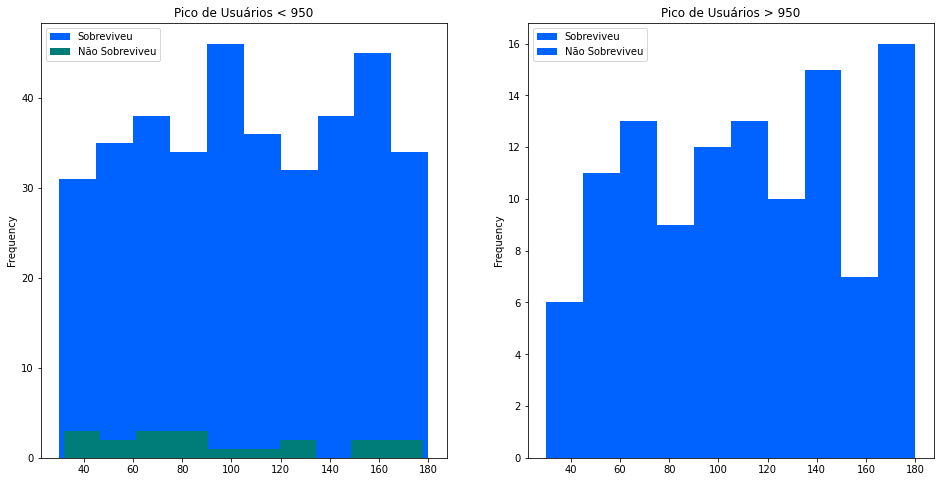

In [46]:
df1 = df[df.max_users<950]
df2 = df[df.max_users>950]
fig, ax = plt.subplots(1,2, figsize=(16,8))
df1.groupby('dead')['time'].plot(kind='hist', ax=ax[0], title='Pico de Usuários < 950')
ax[0].legend(labels=['Sobreviveu', 'Não Sobreviveu'])
df2.groupby('dead')['time'].plot(kind='hist', ax=ax[1], title='Pico de Usuários > 950')
ax[1].legend(labels=['Sobreviveu', 'Não Sobreviveu'])


É possível ver grande diferença dos dois grupos pois o método de agrupamento é um valor delimitador, vamos examinar as curvas de Kaplan-Meier para estas duas subamostras. Isso envolve ajustar o estimador de Kaplan Meier separadamente para cada subamostra.

Text(0, 0.5, 'Taxa de Sobrevivência')

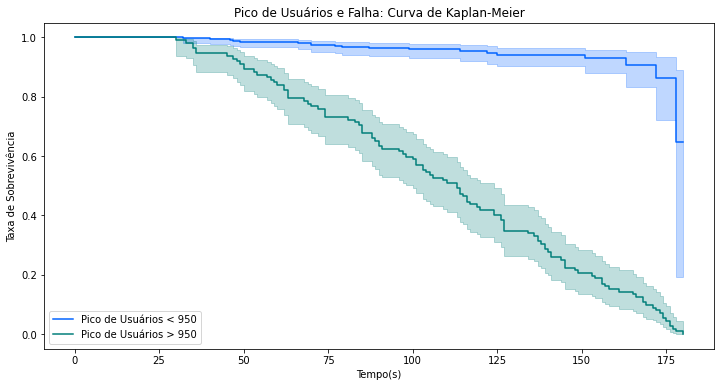

In [48]:
kmf.fit(df1.time, df1.dead)
kmf.plot(label='Pico de Usuários < 950', figsize=(12, 6))
kmf.fit(df2.time, df2.dead)
kmf.plot(label='Pico de Usuários > 950')
plt.title('Pico de Usuários e Falha: Curva de Kaplan-Meier')
plt.xlabel('Tempo(s)')
plt.ylabel('Taxa de Sobrevivência')
